In [251]:
import pandas as pd

In [252]:
df1 = pd.read_csv('data/after/MALAYSIA_GE15_PARLIAMENT_ELECTIONS_v25122022.csv')
df2 = pd.read_csv('data/after/MALAYSIA_PRN6_2023_ELECTION_RESULTS.csv')
cdf = pd.read_csv('data/MALAYSIA_2022_PARLIAMENT_COMPOSITION.csv')
cdf['Classification'] = cdf[ 'URBAN-RURAL CLASSIFICATION (2022)']
cdf2 = cdf[['PARLIAMENTARY CODE', 'Classification']].set_index('PARLIAMENTARY CODE')

fdf2 = df2[['UNIQUE CODE', 'PARLIAMENTARY CODE', 'TOTAL ELECTORATE', 'TOTAL VALID VOTES',  'BN VOTE', 'PH VOTE', 'PN VOTE']].copy()
sdf2 = fdf2.groupby("PARLIAMENTARY CODE")[['TOTAL ELECTORATE',  'TOTAL VALID VOTES',  'BN VOTE', 'PH VOTE', 'PN VOTE']].sum()
for j in ['BN VOTE', 'PH VOTE', 'PN VOTE']:
    sdf2[f'{j}_pct'] = sdf2[j]/sdf2['TOTAL VALID VOTES']

fdf1 = df1[['PARLIAMENTARY CODE', 'STATE',  'TOTAL ELECTORATE', 'TOTAL VALID VOTES',  'BN VOTE', 'PH VOTE', 'PN VOTE']].copy().set_index('PARLIAMENTARY CODE').fillna(0)
fdf1.columns = [f"GE15_{j}" for j in fdf1.columns]
for j in ['GE15_BN VOTE', 'GE15_PH VOTE', 'GE15_PN VOTE']:
    fdf1[f'{j}_pct'] = fdf1[j]/fdf1['GE15_TOTAL VALID VOTES']                
fdf1
xdf = sdf2.join(fdf1).join(cdf2)
# xdf

In [282]:
def compute_transfer(xdf, groupby='GE15_STATE'):
    final_df = xdf.groupby(groupby)[['TOTAL VALID VOTES', 'TOTAL ELECTORATE', 'BN VOTE', 'PH VOTE', 'PN VOTE', 'GE15_TOTAL VALID VOTES', 'GE15_TOTAL ELECTORATE', 'GE15_BN VOTE', 'GE15_PH VOTE', 'GE15_PN VOTE']].sum()
    cols = []
    for j in ['BN', 'PH', 'PN']:
        # final_df[f'{j}_GE15'] = final_df[f'GE15_{j} VOTE']/final_df['GE15_TOTAL ELECTORATE']
        # final_df[f'{j}_PRN'] = final_df[f'{j} VOTE']/final_df['TOTAL ELECTORATE']
        final_df[f'{j}_GE15'] = final_df[f'GE15_{j} VOTE']/final_df['GE15_TOTAL VALID VOTES']
        final_df[f'{j}_PRN'] = final_df[f'{j} VOTE']/final_df['TOTAL VALID VOTES']
        cols.append(f'GE15_{j} VOTE')
        cols.append(f'{j} VOTE')    
    tdf = final_df.groupby(groupby)[cols].sum()

    tdf['GE15_Unity'] = tdf[['GE15_BN VOTE', 'GE15_PH VOTE']].sum(axis=1)
    tdf['PRN_Unity'] = tdf[['BN VOTE', 'PH VOTE']].sum(axis=1)
    tdf['GE15_Total'] = tdf[['GE15_BN VOTE', 'GE15_PH VOTE', 'GE15_PN VOTE']].sum(axis=1)
    tdf['PRN_Total'] = tdf[['BN VOTE', 'PH VOTE', 'PN VOTE']].sum(axis=1)

    tdf['Unity_Transfer'] = (tdf['PRN_Unity'])/(tdf['GE15_Unity']/2)
    tdf['PN_Transfer'] = (tdf['PN VOTE']-tdf['GE15_PN VOTE'])/(tdf['GE15_Unity']/2)
    tdf['No_Turnout'] = (tdf['GE15_Total']-tdf['PRN_Total'])/(tdf['GE15_Unity']/2)
    
    for j in ['GE15_Total', 'PRN_Total',]:
        tdf[j] = tdf[j].astype(int)
    for j in ['Unity_Transfer', 'PN_Transfer', 'No_Turnout']:
        tdf[j] = tdf[j].round(3)
    # tdf['Unity_Transfer'] = (tdf['PRN_Unity']-tdf['GE15_Unity'])/tdf['GE15_Unity']
    # tdf['Shift_To_PN'] = (tdf['PN VOTE']-tdf['GE15_PN VOTE'])/tdf['GE15_Unity']
    # tdf['Lower_Turnout'] = -1*tdf['Unity_Transfer'] - tdf['Shift_To_PN']
    return tdf[['GE15_Total', 'PRN_Total',  'Unity_Transfer', 'PN_Transfer', 'No_Turnout']]


## By States

,GE15_Total,PRN_Total,Unity_Transfer,PN_Transfer,No_Turnout
GE15_STATE,,,,,
KEDAH,"1,181,596","1,144,602",1.35,0.50,0.14
KELANTAN,"985,002","843,723",1.47,-0.27,0.80
NEGERI SEMBILAN,"652,792","574,031",1.40,0.29,0.31
PULAU PINANG,"921,602","876,801",1.69,0.18,0.13
SELANGOR,"2,864,142","2,634,363",1.58,0.20,0.22
TERENGGANU,"736,546","690,115",1.58,0.08,0.34


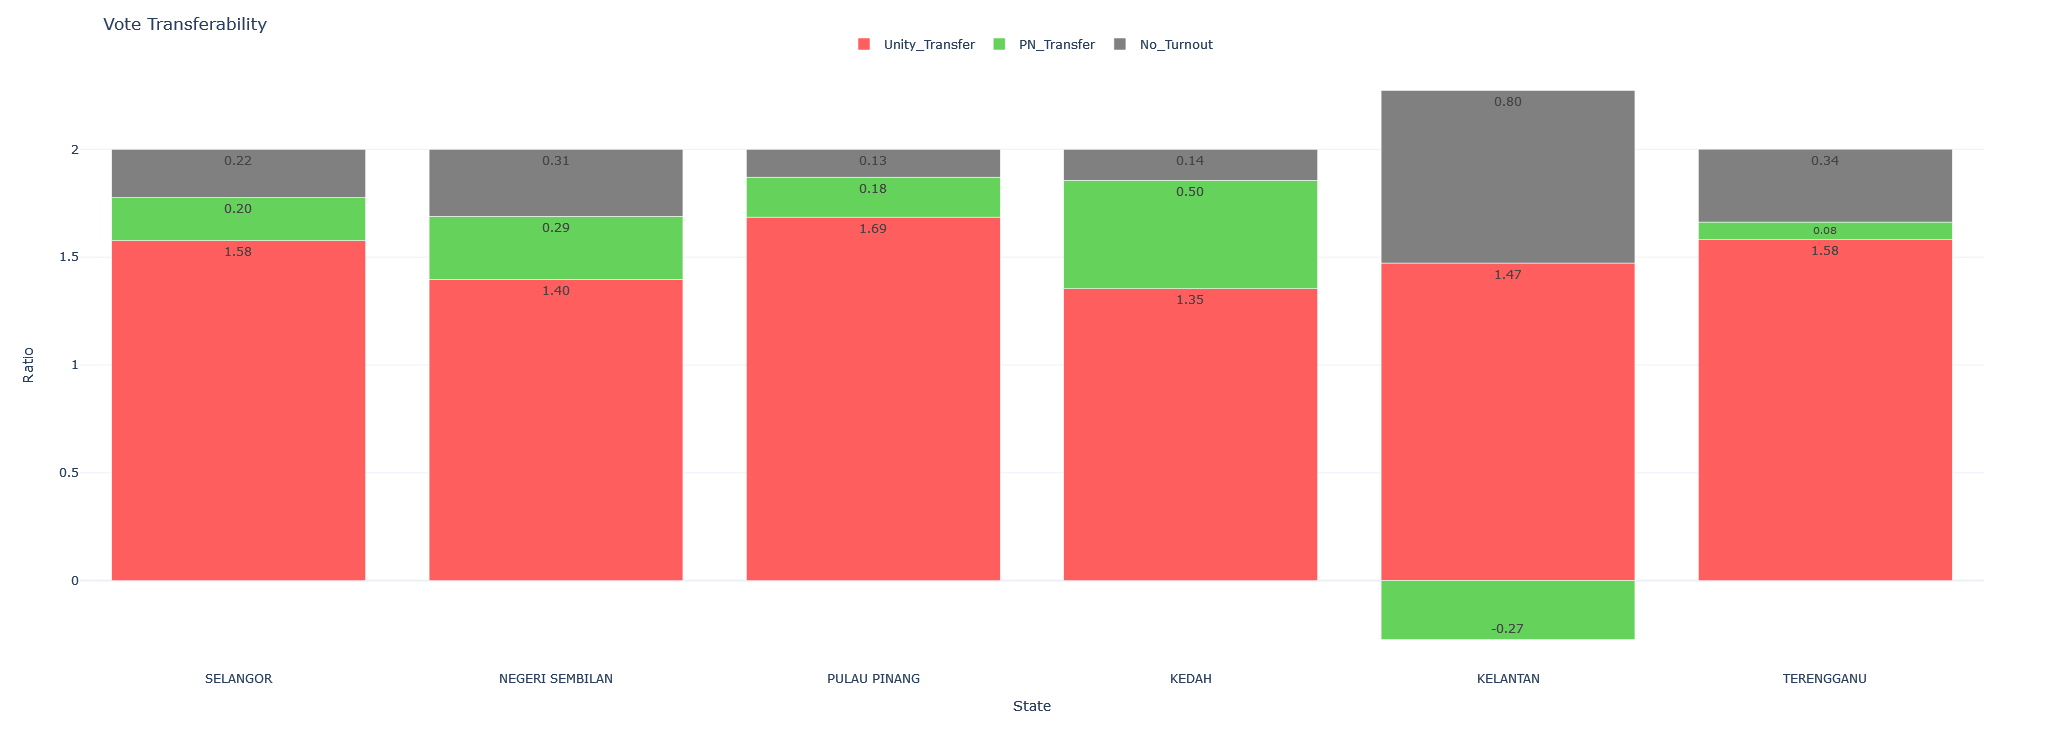

In [314]:
state_df = compute_transfer(xdf, groupby='GE15_STATE')

display(state_df.style.format("{:,}", ['GE15_Total', 'PRN_Total']).format("{:.2f}", ['Unity_Transfer', 'PN_Transfer', 'No_Turnout']))
long_df = state_df[['Unity_Transfer', 'PN_Transfer', 'No_Turnout']].reset_index().melt(id_vars='GE15_STATE')
long_df.columns = ['State', 'Transfer', 'Ratio']

color_mapping = {
    'Unity_Transfer': '#FF5E5E',  # Darker pastel red
    'PN_Transfer': '#65D25C',     # Darker pastel green
    'No_Turnout': 'grey'
}
# Create a stacked bar plot using Plotly
fig = px.bar(long_df, x='State', y='Ratio', color='Transfer', barmode='relative', color_discrete_map=color_mapping)
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside',)

custom_order = ['SELANGOR', 'NEGERI SEMBILAN', 'PULAU PINANG', 'KEDAH', 'KELANTAN', 'TERENGGANU']
fig.update_layout(title='Vote Transferability',
    xaxis_title='State',
    yaxis_title='Ratio',
    height=750, width=1450,template='plotly_white', xaxis=dict(categoryorder='array', categoryarray=custom_order),
                      legend=dict(title=None,orientation='h', yanchor='top', y=1.05, xanchor='center', x=0.5)  # Centered legend at the top
                 
                 )
fig.show(config={'displayModeBar': False} )
          

## By Classification

,GE15_Total,PRN_Total,Unity_Transfer,PN_Transfer,No_Turnout
Classification,,,,,
RURAL,"823,155","768,849",1.37,0.34,0.29
SEMI URBAN,"2,813,788","2,591,189",1.45,0.23,0.32
URBAN,"3,704,737","3,403,597",1.61,0.17,0.23


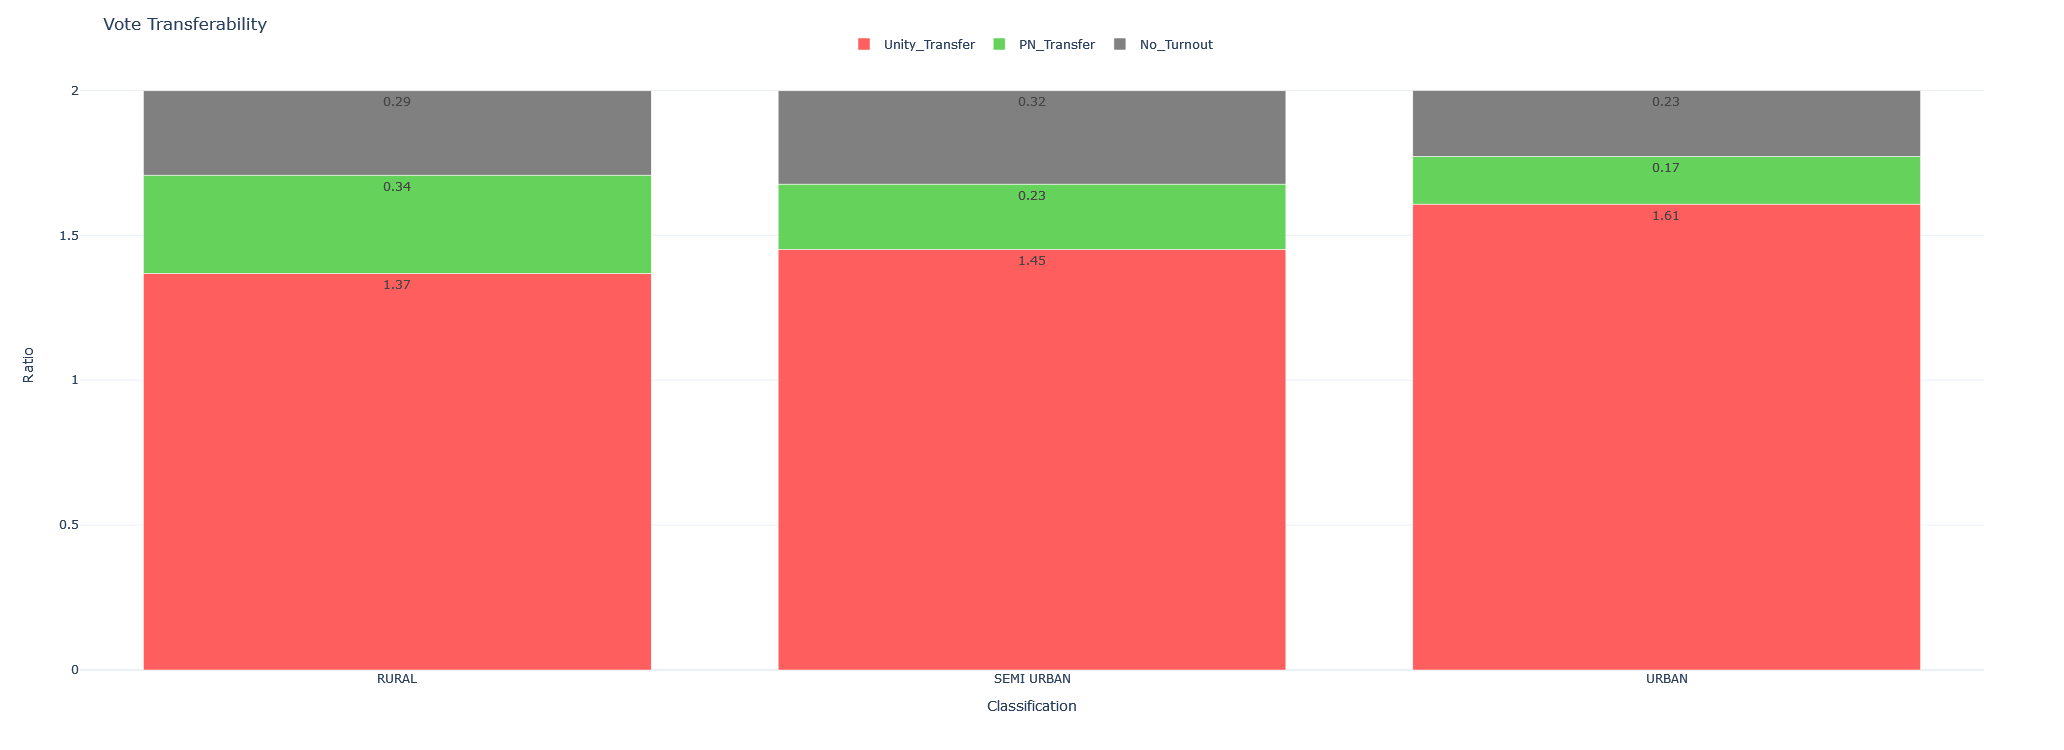

In [304]:
grp_df2 = compute_transfer(xdf, groupby='Classification')

display(grp_df2.style.format("{:,}", ['GE15_Total', 'PRN_Total']).format("{:.2f}", ['Unity_Transfer', 'PN_Transfer', 'No_Turnout']))
long_df = grp_df2[['Unity_Transfer', 'PN_Transfer', 'No_Turnout']].reset_index().melt(id_vars='Classification')
long_df.columns = ['Classification', 'Transfer', 'Ratio']

color_mapping = {
    'Unity_Transfer': '#FF5E5E',  # Darker pastel red
    'PN_Transfer': '#65D25C',     # Darker pastel green
    'No_Turnout': 'grey'
}
# Create a stacked bar plot using Plotly
fig = px.bar(long_df, x='Classification', y='Ratio', color='Transfer', barmode='relative', color_discrete_map=color_mapping)
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside',)

custom_order = ['SELANGOR', 'NEGERI SEMBILAN', 'PULAU PINANG', 'KEDAH', 'KELANTAN', 'TERENGGANU']
fig.update_layout(title='Vote Transferability',
    xaxis_title='Classification',
    yaxis_title='Ratio',
    height=750, width=1450,template='plotly_white', xaxis=dict(categoryorder='array', categoryarray=custom_order),
                      legend=dict(title=None,orientation='h', yanchor='top', y=1.05, xanchor='center', x=0.5)  # Centered legend at the top
                 
                 )
fig.show(config={'displayModeBar': False} )
          

,GE15_Total,PRN_Total,Unity_Transfer,PN_Transfer,No_Turnout
GE15_STATE,,,,,
KEDAH,"331,671","320,330",1.17,0.65,0.18
KELANTAN,"155,266","133,351",1.52,-0.21,0.69
NEGERI SEMBILAN,"93,004","82,578",1.29,0.42,0.29
SELANGOR,"86,759","85,565",1.45,0.50,0.05
TERENGGANU,"156,455","147,025",1.63,0.07,0.30


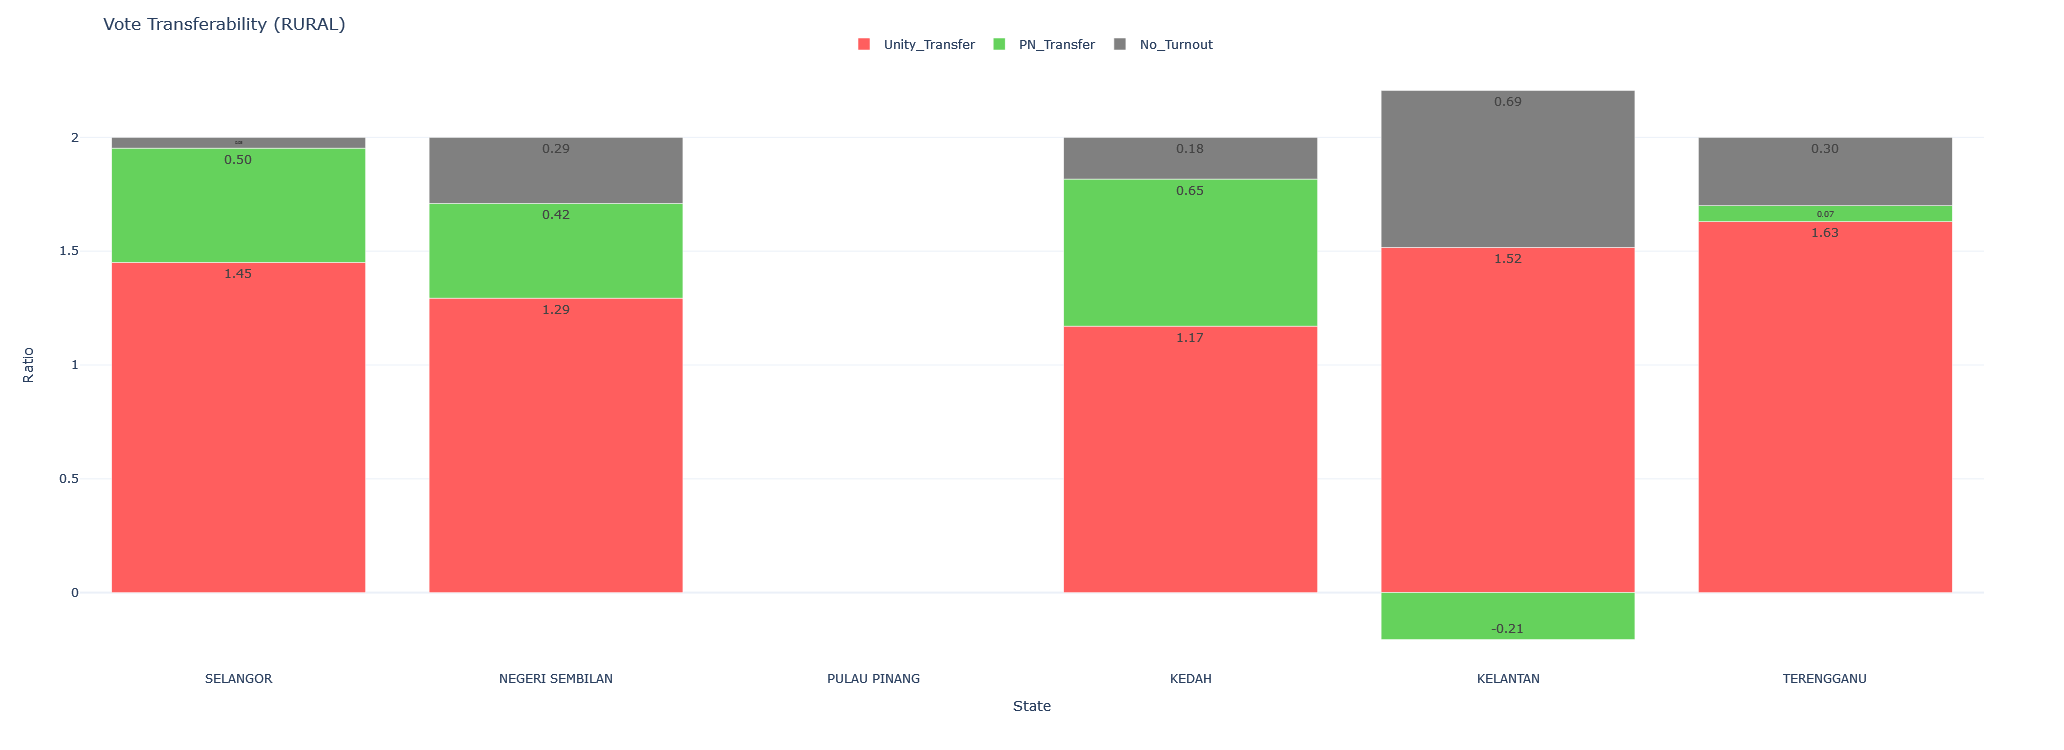

In [315]:
rc = 'RURAL'
grp_df3 = compute_transfer(xdf.query(f'Classification=="{rc}"'), groupby=['GE15_STATE'])

display(grp_df3.style.format("{:,}", ['GE15_Total', 'PRN_Total']).format("{:.2f}", ['Unity_Transfer', 'PN_Transfer', 'No_Turnout']))
long_df = grp_df3[['Unity_Transfer', 'PN_Transfer', 'No_Turnout']].reset_index().melt(id_vars='GE15_STATE')
long_df.columns = ['State', 'Transfer', 'Ratio']

color_mapping = {
    'Unity_Transfer': '#FF5E5E',  # Darker pastel red
    'PN_Transfer': '#65D25C',     # Darker pastel green
    'No_Turnout': 'grey'
}
# Create a stacked bar plot using Plotly
fig = px.bar(long_df, x='State', y='Ratio', color='Transfer', barmode='relative', color_discrete_map=color_mapping)
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside',)

custom_order = ['SELANGOR', 'NEGERI SEMBILAN', 'PULAU PINANG', 'KEDAH', 'KELANTAN', 'TERENGGANU']
fig.update_layout(title=f'Vote Transferability ({rc})',
    xaxis_title='State',
    yaxis_title='Ratio',
    height=750, width=1450,template='plotly_white', xaxis=dict(categoryorder='array', categoryarray=custom_order),
                      legend=dict(title=None,orientation='h', yanchor='top', y=1.05, xanchor='center', x=0.5)  # Centered legend at the top
                 
                 )
fig.show(config={'displayModeBar': False} )
          

In [317]:
xdf['Classification'].unique()

array(['SEMI URBAN', 'RURAL', 'URBAN'], dtype=object)

,GE15_Total,PRN_Total,Unity_Transfer,PN_Transfer,No_Turnout
GE15_STATE,,,,,
KEDAH,"648,518","627,633",1.40,0.45,0.15
KELANTAN,"675,491","574,421",1.44,-0.32,0.87
NEGERI SEMBILAN,"318,517","281,393",1.31,0.39,0.30
PULAU PINANG,"262,635","260,133",1.57,0.40,0.03
SELANGOR,"511,944","477,103",1.50,0.29,0.22
TERENGGANU,"396,683","370,506",1.58,0.07,0.35


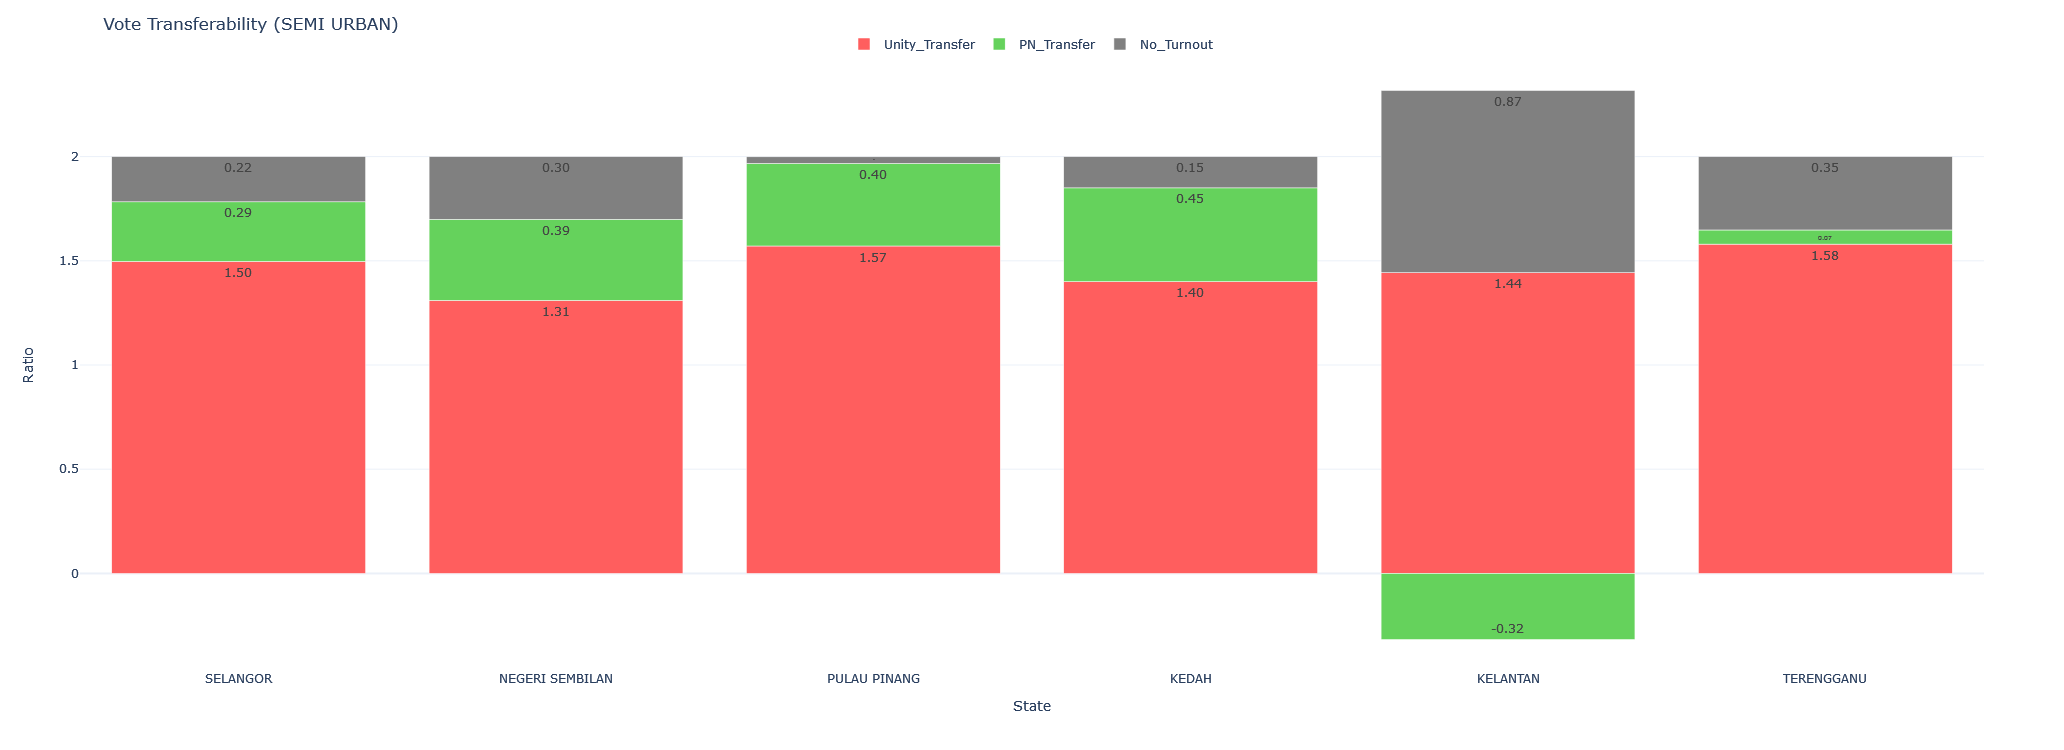

In [318]:
rc = 'SEMI URBAN'
grp_df3 = compute_transfer(xdf.query(f'Classification=="{rc}"'), groupby=['GE15_STATE'])

display(grp_df3.style.format("{:,}", ['GE15_Total', 'PRN_Total']).format("{:.2f}", ['Unity_Transfer', 'PN_Transfer', 'No_Turnout']))
long_df = grp_df3[['Unity_Transfer', 'PN_Transfer', 'No_Turnout']].reset_index().melt(id_vars='GE15_STATE')
long_df.columns = ['State', 'Transfer', 'Ratio']

color_mapping = {
    'Unity_Transfer': '#FF5E5E',  # Darker pastel red
    'PN_Transfer': '#65D25C',     # Darker pastel green
    'No_Turnout': 'grey'
}
# Create a stacked bar plot using Plotly
fig = px.bar(long_df, x='State', y='Ratio', color='Transfer', barmode='relative', color_discrete_map=color_mapping)
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside',)

custom_order = ['SELANGOR', 'NEGERI SEMBILAN', 'PULAU PINANG', 'KEDAH', 'KELANTAN', 'TERENGGANU']
fig.update_layout(title=f'Vote Transferability ({rc})',
    xaxis_title='State',
    yaxis_title='Ratio',
    height=750, width=1450,template='plotly_white', xaxis=dict(categoryorder='array', categoryarray=custom_order),
                      legend=dict(title=None,orientation='h', yanchor='top', y=1.05, xanchor='center', x=0.5)  # Centered legend at the top
                 
                 )
fig.show(config={'displayModeBar': False} )
          

,GE15_Total,PRN_Total,Unity_Transfer,PN_Transfer,No_Turnout
GE15_STATE,,,,,
KEDAH,"201,407","196,639",1.44,0.48,0.08
KELANTAN,"154,245","135,951",1.54,-0.17,0.63
NEGERI SEMBILAN,"241,271","210,060",1.55,0.12,0.33
PULAU PINANG,"658,967","616,668",1.72,0.12,0.16
SELANGOR,"2,265,439","2,071,695",1.60,0.17,0.23
TERENGGANU,"183,408","172,584",1.53,0.12,0.34


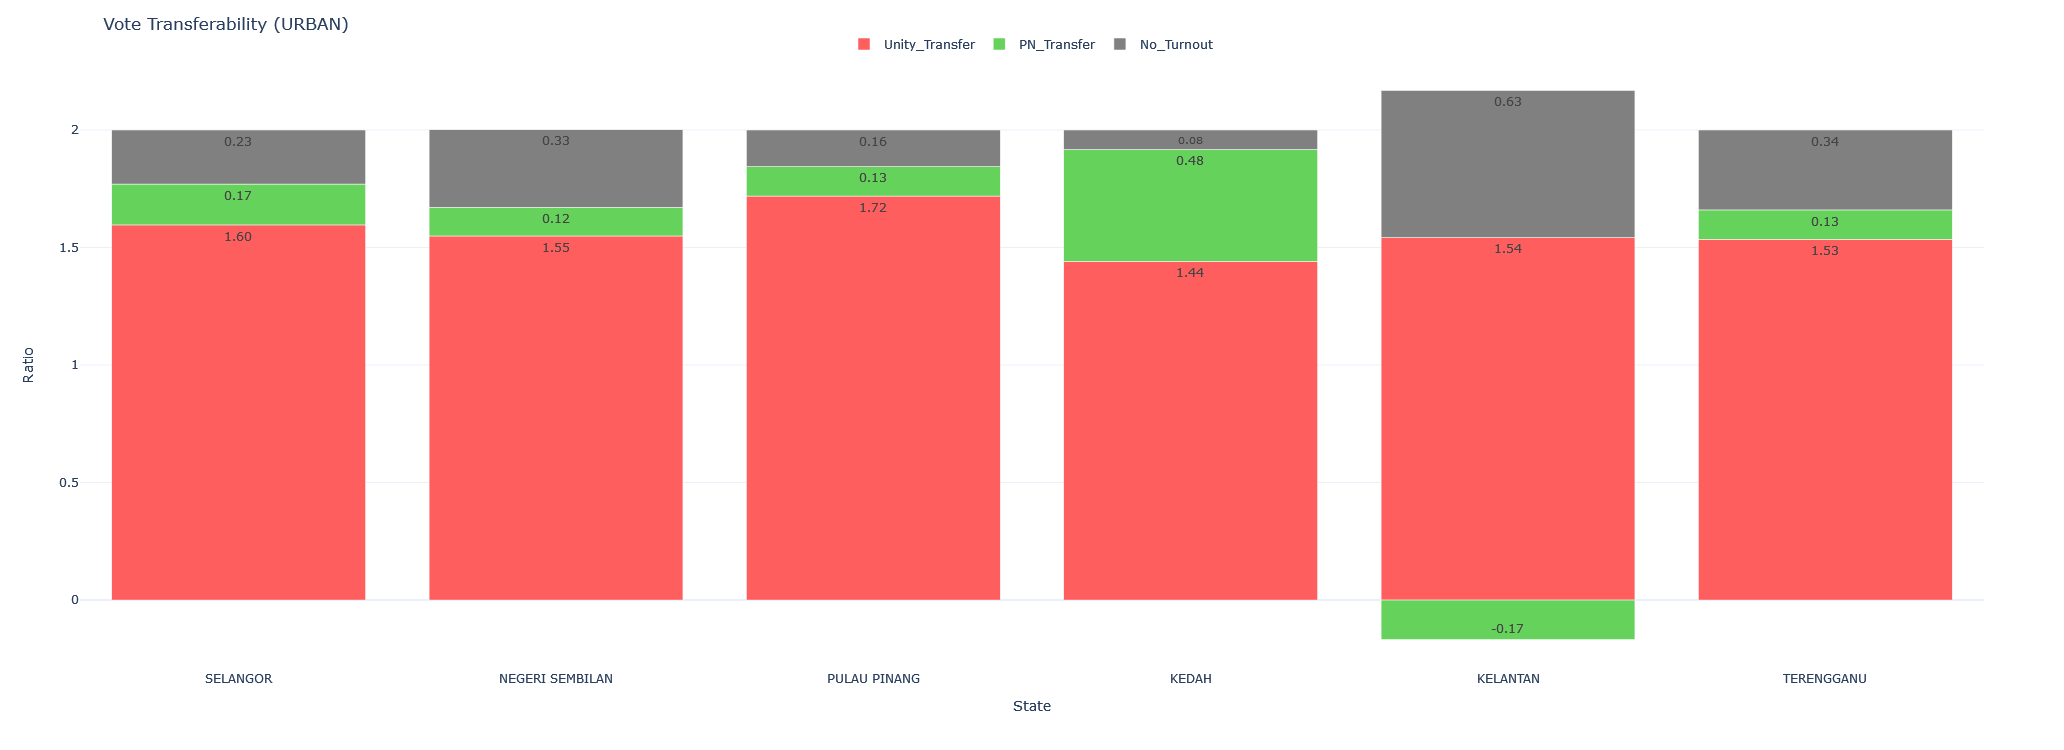

In [319]:
rc = 'URBAN'
grp_df3 = compute_transfer(xdf.query(f'Classification=="{rc}"'), groupby=['GE15_STATE'])

display(grp_df3.style.format("{:,}", ['GE15_Total', 'PRN_Total']).format("{:.2f}", ['Unity_Transfer', 'PN_Transfer', 'No_Turnout']))
long_df = grp_df3[['Unity_Transfer', 'PN_Transfer', 'No_Turnout']].reset_index().melt(id_vars='GE15_STATE')
long_df.columns = ['State', 'Transfer', 'Ratio']

color_mapping = {
    'Unity_Transfer': '#FF5E5E',  # Darker pastel red
    'PN_Transfer': '#65D25C',     # Darker pastel green
    'No_Turnout': 'grey'
}
# Create a stacked bar plot using Plotly
fig = px.bar(long_df, x='State', y='Ratio', color='Transfer', barmode='relative', color_discrete_map=color_mapping)
fig.update_traces(texttemplate='%{y:.2f}', textposition='inside',)

custom_order = ['SELANGOR', 'NEGERI SEMBILAN', 'PULAU PINANG', 'KEDAH', 'KELANTAN', 'TERENGGANU']
fig.update_layout(title=f'Vote Transferability ({rc})',
    xaxis_title='State',
    yaxis_title='Ratio',
    height=750, width=1450,template='plotly_white', xaxis=dict(categoryorder='array', categoryarray=custom_order),
                      legend=dict(title=None,orientation='h', yanchor='top', y=1.05, xanchor='center', x=0.5)  # Centered legend at the top
                 
                 )
fig.show(config={'displayModeBar': False} )
          

In [320]:
grp_df3 = compute_transfer(xdf, groupby=['Classification', 'GE15_STATE'])
display(grp_df3.style.format("{:,}", ['GE15_Total', 'PRN_Total']).format("{:.2f}", ['Unity_Transfer', 'PN_Transfer', 'No_Turnout']))

In [182]:
# xdf[['BN VOTE', 'PH VOTE', 'PN VOTE', 'GE15_BN VOTE', 'GE15_PH VOTE', 'GE15_PN VOTE']].sum()
# urban_df = xdf.groupby('Classification')[['TOTAL VALID VOTES', 'TOTAL ELECTORATE', 'BN VOTE', 'PH VOTE', 'PN VOTE', 'GE15_TOTAL VALID VOTES', 'GE15_TOTAL ELECTORATE', 'GE15_BN VOTE', 'GE15_PH VOTE', 'GE15_PN VOTE']].sum()
# urban_df
compute_transfer(xdf, groupby='Classification')

,GE15_BN VOTE,BN VOTE,GE15_PH VOTE,PH VOTE,GE15_PN VOTE,PN VOTE,GE15_Unity,PRN_Unity,GE15_Total,PRN_Total,Unity_Transfer_Ratio,PN_Transfer_Ratio,NoTurnout_Ratio
Classification,,,,,,,,,,,,,
RURAL,279135.0,188055.0,93512.0,67093.0,450508.0,513701,372647.0,255148.0,823155.0,768849.0,1.369382,0.339157,0.291461
SEMI URBAN,727860.0,530629.0,652913.0,471909.0,1433015.0,1588651,1380773.0,1002538.0,2813788.0,2591189.0,1.452140,0.225433,0.322427
URBAN,594101.0,199308.0,2058267.0,1933344.0,1052369.0,1270945,2652368.0,2132652.0,3704737.0,3403597.0,1.608112,0.164816,0.227073


In [184]:
compute_transfer(xdf, groupby=['Classification', 'GE15_STATE'])

GE15_BN VOTE   BN VOTE  GE15_PH VOTE  \
Classification GE15_STATE                                              
RURAL          KEDAH                 94381.0   47969.0       29281.0   
               KELANTAN              53823.0   44873.0        9805.0   
               NEGERI SEMBILAN       43228.0   29785.0       28620.0   
               SELANGOR              28791.0   16475.0       21941.0   
               TERENGGANU            58912.0   48953.0        3865.0   
SEMI URBAN     KEDAH                104651.0   59837.0      174107.0   
               KELANTAN             180276.0  115139.0       50904.0   
               NEGERI SEMBILAN      124908.0   89723.0      121815.0   
               PULAU PINANG          70739.0   49476.0       83299.0   
               SELANGOR             120847.0  106309.0      200662.0   
               TERENGGANU           126439.0  110145.0       22126.0   
URBAN          KEDAH                 36321.0    8534.0       78135.0   
               KELANTAN              31831.0   18425.0       26612.0   
               NEGERI SEMBILAN       44031.0   10040.0      145354.0   
               PULAU PINANG          72659.0       0.0      468732.0   
               SELANGOR             360218.0  123239.0     1324780.0   
               TERENGGANU            49041.0   39070.0       14654.0   

                                  PH VOTE  GE15_PN VOTE  PN VOTE  GE15_Unity  \
Classification GE15_STATE                                                      
RURAL          KEDAH              24432.0      208009.0   247929    123662.0   
               KELANTAN            3404.0       91638.0    85074     63628.0   
               NEGERI SEMBILAN    16708.0       21156.0    36085     71848.0   
               SELANGOR           20338.0       36027.0    48752     50732.0   
               TERENGGANU          2211.0       93678.0    95861     62777.0   
SEMI URBAN     KEDAH             135313.0      369760.0   432483    278758.0   
               KELANTAN           51643.0      444311.0   407639    231180.0   
               NEGERI SEMBILAN    71854.0       71794.0   119816    246723.0   
               PULAU PINANG       71542.0      108597.0   139115    154038.0   
               SELANGOR          134369.0      190435.0   236425    321509.0   
               TERENGGANU          7188.0      248118.0   253173    148565.0   
URBAN          KEDAH              73909.0       86951.0   114196    114456.0   
               KELANTAN           26641.0       95802.0    90885     58443.0   
               NEGERI SEMBILAN   136618.0       51886.0    63402    189385.0   
               PULAU PINANG      465269.0      117576.0   151399    541391.0   
               SELANGOR         1221090.0      580441.0   727366   1684998.0   
               TERENGGANU          9817.0      119713.0   123697     63695.0   

                                PRN_Unity  GE15_Total  PRN_Total  \
Classification GE15_STATE                                          
RURAL          KEDAH              72401.0    331671.0   320330.0   
               KELANTAN           48277.0    155266.0   133351.0   
               NEGERI SEMBILAN    46493.0     93004.0    82578.0   
               SELANGOR           36813.0     86759.0    85565.0   
               TERENGGANU         51164.0    156455.0   147025.0   
SEMI URBAN     KEDAH             195150.0    648518.0   627633.0   
               KELANTAN          166782.0    675491.0   574421.0   
               NEGERI SEMBILAN   161577.0    318517.0   281393.0   
               PULAU PINANG      121018.0    262635.0   260133.0   
               SELANGOR          240678.0    511944.0   477103.0   
               TERENGGANU        117333.0    396683.0   370506.0   
URBAN          KEDAH              82443.0    201407.0   196639.0   
               KELANTAN           45066.0    154245.0   135951.0   
               NEGERI SEMBILAN   146658.0    241271.0   210060.0   
               PULAU PINANG      465269.0    658967.0 

,GE15_BN VOTE,BN VOTE,GE15_PH VOTE,PH VOTE,GE15_PN VOTE,PN VOTE,GE15_Unity,PRN_Unity,Unity_Transfer,Shift_To_PN,Lower_Turnout,Unity_Transfer_Ratio,PN_Transfer_Ratio,GE15_Total,PRN_Total,NoTurnout_Ratio
GE15_STATE,,,,,,,,,,,,,,,,
KEDAH,235353.0,116340.0,281523.0,233654.0,664720.0,794608,516876.0,349994.0,-0.322867,0.251294,0.071572,1.354267,0.502589,1181596.0,1144602.0,0.143145
KELANTAN,265930.0,178437.0,87321.0,81688.0,631751.0,583598,353251.0,260125.0,-0.263626,-0.136314,0.399939,1.472749,-0.272628,985002.0,843723.0,0.799879
NEGERI SEMBILAN,212167.0,129548.0,295789.0,225180.0,144836.0,219303,507956.0,354728.0,-0.301656,0.146601,0.155055,1.396688,0.293203,652792.0,574031.0,0.310110
PULAU PINANG,143398.0,49476.0,552031.0,536811.0,226173.0,290514,695429.0,586287.0,-0.156942,0.092520,0.064422,1.686116,0.185040,921602.0,876801.0,0.128844
SELANGOR,509856.0,246023.0,1547383.0,1375797.0,806903.0,1012543,2057239.0,1621820.0,-0.211652,0.099959,0.111693,1.576696,0.199918,2864142.0,2634363.0,0.223386
TERENGGANU,234392.0,198168.0,40645.0,19216.0,461509.0,472731,275037.0,217384.0,-0.209619,0.040802,0.168817,1.580762,0.081604,736546.0,690115.0,0.337635


In [112]:
(917992+2472346)/ ( 1601096+2804692), 3373297 - 2935892

(0.7695190962433962, 437405)

In [99]:
final_df['Unity_GE15'] = final_df[['BN_GE15', 'PH_GE15']].sum(axis=1)
final_df['Unity_PRN'] = final_df[['BN_PRN', 'PH_PRN']].sum(axis=1)
final_df

,TOTAL VALID VOTES,TOTAL ELECTORATE,BN VOTE,PH VOTE,PN VOTE,GE15_TOTAL VALID VOTES,GE15_TOTAL ELECTORATE,GE15_BN VOTE,GE15_PH VOTE,GE15_PN VOTE,BN_GE15,BN_PRN,PH_GE15,PH_PRN,PN_GE15,PN_PRN,Unity_GE15,Unity_PRN
GE15_STATE,,,,,,,,,,,,,,,,,,
KEDAH,1155797,1585085,116340.0,233654.0,794608,1209539,1575805,235353.0,281523.0,664720.0,0.194581,0.100658,0.232752,0.202158,0.549565,0.687498,0.427333,0.302816
KELANTAN,845743,1411912,178437.0,81688.0,583598,992408,1404763,265930.0,87321.0,631751.0,0.267964,0.210983,0.087989,0.096587,0.636584,0.690042,0.355953,0.307570
NEGERI SEMBILAN,582455,864425,129548.0,225180.0,219303,659425,850865,212167.0,295789.0,144836.0,0.321745,0.222417,0.448556,0.386605,0.219640,0.376515,0.770301,0.609022
PULAU PINANG,884532,1234198,49476.0,536811.0,290514,943971,1226626,143398.0,552031.0,226173.0,0.151909,0.055935,0.584797,0.606887,0.239597,0.328438,0.736706,0.662822
SELANGOR,2676774,3747057,246023.0,1375797.0,1012543,2930276,3677848,509856.0,1547383.0,806903.0,0.173996,0.091910,0.528067,0.513976,0.275368,0.378270,0.702063,0.605886
TERENGGANU,690667,930894,198168.0,19216.0,472731,739816,922856,234392.0,40645.0,461509.0,0.316825,0.286923,0.054939,0.027822,0.623816,0.684456,0.371764,0.314745


In [88]:
# 1601096+2804692, 917992+2472346, 3373297-2935892

In [79]:
final_df

,TOTAL ELECTORATE,BN VOTE,PH VOTE,PN VOTE,GE15_TOTAL ELECTORATE,GE15_BN VOTE,GE15_PH VOTE,GE15_PN VOTE,BN_GE15,BN_PRN,PH_GE15,PH_PRN,PN_GE15,PN_PRN
GE15_STATE,,,,,,,,,,,,,,
KEDAH,1585085,116340.0,233654.0,794608,1575805,235353.0,281523.0,664720.0,0.149354,0.073397,0.178653,0.147408,0.421829,0.501303
KELANTAN,1411912,178437.0,81688.0,583598,1404763,265930.0,87321.0,631751.0,0.189306,0.126380,0.062161,0.057856,0.449721,0.413339
NEGERI SEMBILAN,864425,129548.0,225180.0,219303,850865,212167.0,295789.0,144836.0,0.249354,0.149866,0.347633,0.260497,0.170222,0.253698
PULAU PINANG,1234198,49476.0,536811.0,290514,1226626,143398.0,552031.0,226173.0,0.116904,0.040088,0.450040,0.434947,0.184386,0.235387
SELANGOR,3747057,246023.0,1375797.0,1012543,3677848,509856.0,1547383.0,806903.0,0.138629,0.065658,0.420731,0.367167,0.219395,0.270224
TERENGGANU,930894,198168.0,19216.0,472731,922856,234392.0,40645.0,461509.0,0.253985,0.212879,0.044043,0.020643,0.500088,0.507825


,TOTAL ELECTORATE,BN VOTE,PH VOTE,PN VOTE,GE15_TOTAL ELECTORATE,GE15_BN VOTE,GE15_PH VOTE,GE15_PN VOTE,BN_GE15,BN_PRN,PH_GE15,PH_PRN,PN_GE15,PN_PRN,Unity_GE15,Unity_PRN
GE15_STATE,,,,,,,,,,,,,,,,
KEDAH,1585085,116340.0,233654.0,794608,1575805,235353.0,281523.0,664720.0,0.149354,0.073397,0.178653,0.147408,0.421829,0.501303,0.328008,0.220805
KELANTAN,1411912,178437.0,81688.0,583598,1404763,265930.0,87321.0,631751.0,0.189306,0.126380,0.062161,0.057856,0.449721,0.413339,0.251467,0.184236
NEGERI SEMBILAN,864425,129548.0,225180.0,219303,850865,212167.0,295789.0,144836.0,0.249354,0.149866,0.347633,0.260497,0.170222,0.253698,0.596988,0.410363
PULAU PINANG,1234198,49476.0,536811.0,290514,1226626,143398.0,552031.0,226173.0,0.116904,0.040088,0.450040,0.434947,0.184386,0.235387,0.566945,0.475035
SELANGOR,3747057,246023.0,1375797.0,1012543,3677848,509856.0,1547383.0,806903.0,0.138629,0.065658,0.420731,0.367167,0.219395,0.270224,0.559359,0.432825
TERENGGANU,930894,198168.0,19216.0,472731,922856,234392.0,40645.0,461509.0,0.253985,0.212879,0.044043,0.020643,0.500088,0.507825,0.298028,0.233522
